# Import Libaries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

import os
os.chdir("/content/gdrive/MyDrive/QuoraQuestions")
!ls

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Open DF

In [ ]:
train_df = pd.read_csv("train.csv")
train_df = train_df.dropna()

train_df["id"].astype('int64', copy=False)
train_df["qid1"].astype('int64', copy=False)
train_df["qid2"].astype('int64', copy=False)
train_df["question1"].astype('string', copy=False)
train_df["question2"].astype('string', copy=False)
train_df["is_duplicate"].astype('int64', copy=False)

print("total number of samples: ", len(train_df))
print("number of negative samples: " , len(train_df[train_df['is_duplicate'] == 0]))
print("number of positive samples: " , len(train_df[train_df['is_duplicate'] == 1]))

print(train_df.head())
print(train_df.columns)

total number of samples:  404287
number of negative samples:  255024
number of positive samples:  149263
   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  
Index(['id', 'qid1', 'qid2', 'question1', 'quest

In [ ]:
train_df[train_df.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate


In [ ]:
max_id = max(train_df['id'])
max_qid = max(max(train_df['qid1']), max(train_df['qid2']))

# Data Generation

In [ ]:
#if A and B are duplicates and B and C are duplicate, it is reasonable to assume that A and C are duplicates

id_to_sentence = {}
for idx, sample in train_df.iterrows():
    sample1_id = sample['qid1']
    sample2_id = sample['qid2']

    if sample1_id not in id_to_sentence.keys():
        id_to_sentence[sample1_id] = sample['question1']
    
    if sample2_id not in id_to_sentence.keys():
        id_to_sentence[sample2_id] = sample['question2']

print(id_to_sentence[10])

Which fish would survive in salt water?


In [ ]:
duplicate_dict = {}

def get_linking_dict(output_dict, is_duplicate):
    for idx, sample in train_df[train_df['is_duplicate'] == is_duplicate].iterrows():
        sample1_id = sample['qid1']
        sample2_id = sample['qid2']

        if sample1_id in output_dict.keys():
            output_dict[sample1_id].append(sample2_id)
        else:
            output_dict[sample1_id] = [sample2_id]

        if sample2_id in output_dict.keys():
            output_dict[sample2_id].append(sample1_id)
        else:
            output_dict[sample2_id] = [sample1_id]

get_linking_dict(duplicate_dict, 1)
print(len(duplicate_dict))

149650


In [ ]:
def f(pdict, index, isduplicate):
    id_list = []
    qid1_list = []
    qid2_list = []
    question1_list = []
    question2_list = []
    is_duplicate_list = []

    for A in pdict.keys():
        A_list = pdict[A]
        for B in A_list:
            B_list = pdict[B]
            for C in B_list:
                if C == A:
                    pass
                else:
                    C_list = pdict[C]
                    if A not in C_list:
                        id_list.append(index)
                        index = index + 1

                        qid1_list.append(A)
                        qid2_list.append(C)

                        question1_list.append(id_to_sentence[A])
                        question2_list.append(id_to_sentence[C])

                        is_duplicate_list.append(isduplicate)
    
    d = {'id': id_list, 'qid1': qid1_list, 'qid2':qid2_list, 'question1':question1_list, 'question2':question2_list, 'is_duplicate':is_duplicate_list}
    df = pd.DataFrame(data=d)
    return df, index

duplicate_pairs_df, index = f(duplicate_dict, max_id + 1, 1)


In [ ]:
full_train_df = pd.concat([train_df, duplicate_pairs_df], axis=0, ignore_index=True)

print("total number of samples: ", len(full_train_df))
print("number of negative samples: " , len(full_train_df[full_train_df['is_duplicate'] == 0]))
print("number of positive samples: " , len(full_train_df[full_train_df['is_duplicate'] == 1]))

print(full_train_df.columns)
print(full_train_df)

total number of samples:  800169
number of negative samples:  255024
number of positive samples:  545145
Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')
            id    qid1    qid2  \
0            0       1       2   
1            1       3       4   
2            2       5       6   
3            3       7       8   
4            4       9      10   
...        ...     ...     ...   
800164  800167  537487  145473   
800165  800168  537580   67133   
800166  800169  537580  168082   
800167  800170  537762  132589   
800168  800171  537894  187745   

                                                question1  \
0       What is the step by step guide to invest in sh...   
1       What is the story of Kohinoor (Koh-i-Noor) Dia...   
2       How can I increase the speed of my internet co...   
3       Why am I mentally very lonely? How can I solve...   
4       Which one dissolve in water quikly sugar, salt...   
...                             

In [ ]:
full_train_df.to_csv("fulltrain.csv",index=False)

# Data Cleaning Functions

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from functools import lru_cache
from nltk.corpus import wordnet


from bs4 import BeautifulSoup
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\teohq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\teohq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\teohq\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\teohq\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# data cleaning
lemmatizer = WordNetLemmatizer()  
lemmatize = lru_cache(maxsize=100000)(lemmatizer.lemmatize)

def processQuestion(qn, isRemoveStopWords, isLemmatize):
  # Convert text to lower case.
  qn = str(qn).lower().strip()

  # Replace some numerical values with strings. This should run after remove punctuation.
  numberDictionary = {
      "000": " thousand ", 
      "000000": " million ", 
      "000000000": " billion "
  }
  for item in numberDictionary.items():
    qn = qn.replace(item[0], item[1])
  
  # Replace some characters with their string equivalents (Eg: $, %, + etc.).
  symbolDictionary = {
      "$": " dollar ", 
      "€": " euro ",
      '₹': " rupee ",
      "£": " pound ",
      "%": " percent ", 
      "+": " plus ",
      '&': " and ",
      '#': " hashtag ",
      '@': " at "
  }
  for item in symbolDictionary.items():
    qn = qn.replace(item[0], item[1])
  
  # Decontract words (“don’t” becomes “do not”). Modifed from https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
  contractions = { 
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he has",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }
  for item in contractions.items():
    qn = qn.replace(item[0], item[1])
  
  edge_contractions = {
      "'ve": "have",
      "n't": "not",
      "'re": "are",
      "'ll": "will"
  }
  for item in edge_contractions.items():
    qn = qn.replace(item[0], item[1])

  # Remove punctuation.
  qn = re.sub('\W+',' ', qn )

  #remove in between whitespace
  qn = re.sub(' +', ' ', qn)

  # Stop word removal.
  if isRemoveStopWords:
    stop_words = set(stopwords.words("english"))
    qn = ' '.join([word for word in nltk.word_tokenize(qn) if not word in stop_words])

  # Lemmatization with POS
  # Map POS tag to first character lemmatize() accepts
  if isLemmatize:
    def get_wordnet_pos(word):
      tag = nltk.pos_tag([word])[0][1][0].upper()
      tag_dict = {"J": wordnet.ADJ,
                  "N": wordnet.NOUN,
                  "V": wordnet.VERB,
                  "R": wordnet.ADV}
      return tag_dict.get(tag, wordnet.NOUN)
    
    
    qn = ' '.join([lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(qn)])

  return qn

print(id_to_sentence[101])
processQuestion(id_to_sentence[101], True, True)


Is Career Launcher good for RBI Grade B preparation?


'career launcher good rbi grade b preparation'

# Data Cleaning

In [ ]:
def get_dict_element(x, somedict):
    return somedict[x]

In [ ]:
cleaned_sentences = {}
print(len(id_to_sentence.keys()))
for currentid in id_to_sentence.keys():
    cleaned_sentences[currentid] = processQuestion(id_to_sentence[currentid], False, False)
    
    if currentid % 100000 == 0:
        print("done till ", currentid)

full_train_df['question1_cleaned'] = full_train_df['qid1'].apply(lambda x: get_dict_element(x, cleaned_sentences))
full_train_df['question2_cleaned'] = full_train_df['qid2'].apply(lambda x: get_dict_element(x, cleaned_sentences))

537929
done till  100000
done till  200000
done till  300000
done till  400000
done till  500000


In [ ]:
cleaned_stopwords_lemmatize_sentences = {}
for currentid in id_to_sentence.keys():
    cleaned_stopwords_lemmatize_sentences[currentid] = processQuestion(id_to_sentence[currentid], True, True)
    
    if currentid % 100000 == 0:
        print("done till ", currentid)

full_train_df['question1_stopwords_lemmatize'] = full_train_df['qid1'].apply(lambda x: get_dict_element(x, cleaned_stopwords_lemmatize_sentences))
full_train_df['question2_stopwords_lemmatize'] = full_train_df['qid2'].apply(lambda x: get_dict_element(x, cleaned_stopwords_lemmatize_sentences))


done till  100000
done till  200000
done till  300000
done till  400000
done till  500000


In [ ]:
cleaned_stopwords_sentences = {}
for currentid in id_to_sentence.keys():
    cleaned_stopwords_sentences[currentid] = processQuestion(id_to_sentence[currentid], True, False)
    
    if currentid % 100000 == 0:
        print("done till ", currentid)

full_train_df['question1_stopwords'] =  full_train_df['qid1'].apply(lambda x: get_dict_element(x, cleaned_stopwords_sentences))
full_train_df['question2_stopwords'] =  full_train_df['qid2'].apply(lambda x: get_dict_element(x, cleaned_stopwords_sentences))

done till  100000
done till  200000
done till  300000
done till  400000
done till  500000


In [ ]:
full_train_df


,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question2_cleaned,question1_stopwords_lemmatize,question2_stopwords_lemmatize,question1_stopwords,question2_stopwords
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,step step guide invest share market india,step step guide invest share market,step step guide invest share market india,step step guide invest share market
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,increase speed internet connection use vpn,internet speed increase hack dns,increase speed internet connection using vpn,internet speed increased hacking dns
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math is div...,mentally lonely solve,find remainder math 23 24 math divide 24 23,mentally lonely solve,find remainder math 23 24 math divided 24 23
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,one dissolve water quikly sugar salt methane c...,fish would survive salt water,one dissolve water quikly sugar salt methane c...,fish would survive salt water
...,...,...,...,...,...,...,...,...,...,...,...,...
800164,800167,537487,145473,What does that mean if a girl calls you crazy?,"If a girl says ""you are crazy"", what does it m...",1,what does that mean if a girl calls you crazy,if a girl says you are crazy what does it mean,mean girl call crazy,girl say crazy mean,mean girl calls crazy,girl says crazy mean
800165,800168,537580,67133,How do I determine if I am bisexual or lesbian?,"Am I bisexual, lesbian or straight?",1,how do i determine if i am bisexual or lesbian,am i bisexual lesbian or straight,determine bisexual lesbian,bisexual lesbian straight,determine bisexual lesbian,bisexual lesbian straight
800166,800169,537580,168082,How do I determine if I am bisexual or lesbian?,"How do I know if I am bisexual, lesbian or str...",1,how do i determine if i am bisexual or lesbian,how do i know if i am bisexual lesbian or stra...,determine bisexual lesbian,know bisexual lesbian straight,determine bisexual lesbian,know bisexual lesbian straight
800167,800170,537762,132589,What is your favorite vodka drink and why?,What is your favourite vodka?,1,what is your favorite vodka drink and why,what is your favourite vodka,favorite vodka drink,favourite vodka,favorite vodka drink,favourite vodka


In [ ]:
train_df[train_df.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate


In [ ]:
print(full_train_df[0:100][['question1', 'question1_cleaned', 'question1_stopwords', 'question1_stopwords_lemmatize']])
print(full_train_df[0:100][['question2', 'question2_cleaned', 'question2_stopwords', 'question2_stopwords_lemmatize']])

                                            question1  \
0   What is the step by step guide to invest in sh...   
1   What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   How can I increase the speed of my internet co...   
3   Why am I mentally very lonely? How can I solve...   
4   Which one dissolve in water quikly sugar, salt...   
..                                                ...   
95                         How does 3D printing work?   
96  What was it like to attend Caltech with Jeremy...   
97                    Why did harry become a horcrux?   
98  What are the best associate product manager (A...   
99  Why is the number for Skype at 1-855-425-3768 ...   

                                    question1_cleaned  \
0   what is the step by step guide to invest in sh...   
1   what is the story of kohinoor koh i noor diamond    
2   how can i increase the speed of my internet co...   
3   why am i mentally very lonely how can i solve it    
4   which one dissolve in wate

In [ ]:
full_train_df.to_csv("fulltrain_cleaned.csv",index=False)

# Some Visualizations

In [ ]:
clean_sentence_list = full_train_df['question1_cleaned'].tolist()
clean_sentence_list = clean_sentence_list + full_train_df['question2_cleaned'].tolist()

print(len(clean_sentence_list))
print(clean_sentence_list[0])

1600338
what is the step by step guide to invest in share market in india 


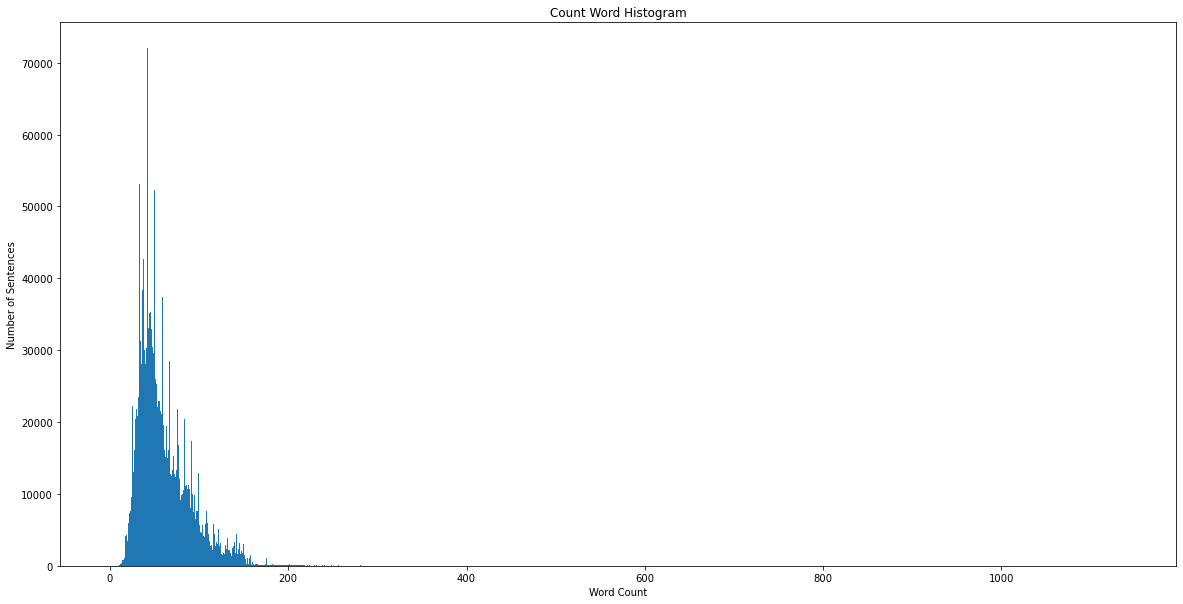

In [ ]:
word_count = []
for sentence in clean_sentence_list:
    if isinstance(sentence, float):
        print(sentence)
    word_count.append(len(sentence))

plt.figure(figsize=(20,10))
plt.hist(word_count, bins=1000)
plt.gca().set(title='Count Word Histogram', ylabel='Number of Sentences', xlabel='Word Count')
plt.show()

<AxesSubplot:xlabel='ReviewText'>

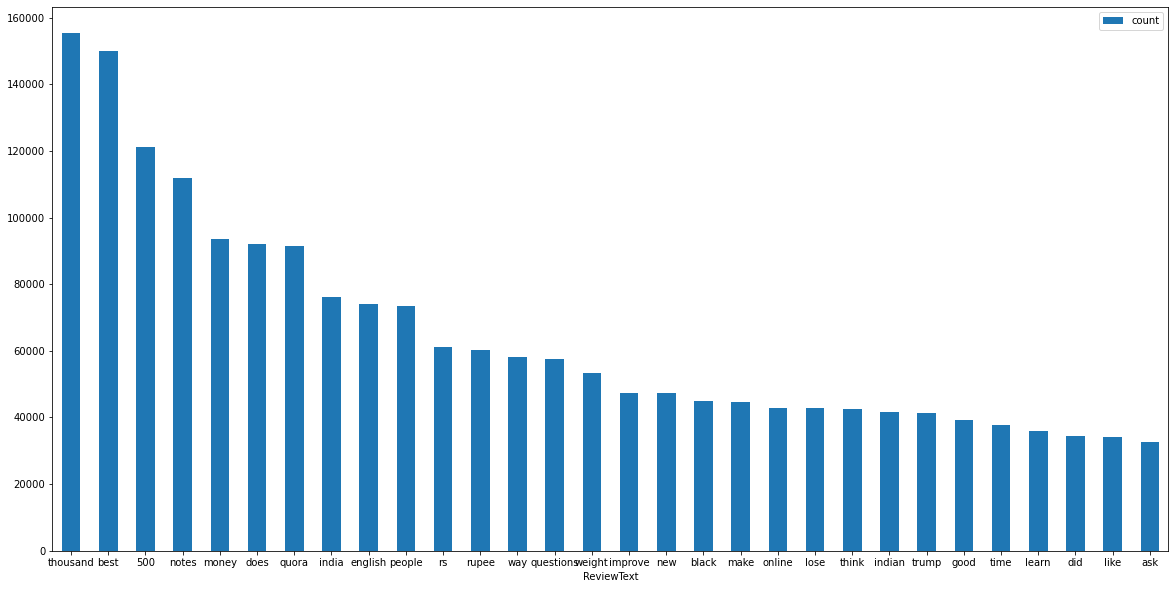

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(clean_sentence_list, 30)
df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df2.plot.bar(x='ReviewText', y='count', rot=0, figsize=(20,10))


In [ ]:
sentence_list = full_train_df['question1_stopwords_lemmatize'].tolist()
sentence_list = sentence_list + full_train_df['question2_stopwords_lemmatize'].tolist()

<Figure size 432x288 with 0 Axes>

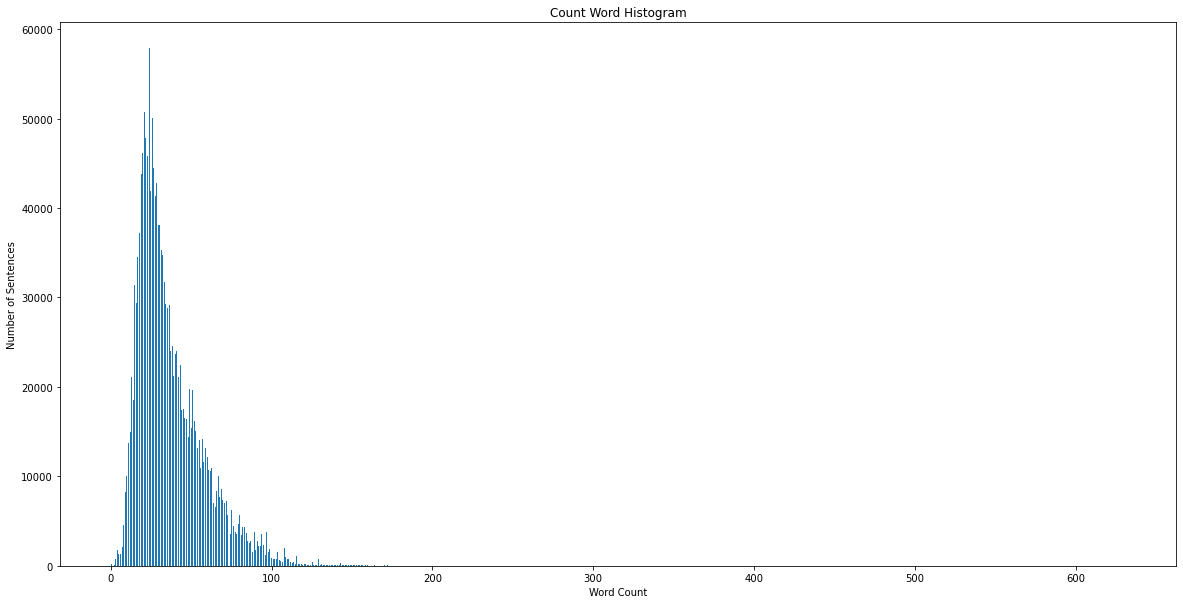

In [ ]:
word_count = []
for sentence in sentence_list:
    sentence = str(sentence)
    word_count.append(len(sentence))

plt.clf()
plt.figure(figsize=(20,10))
plt.hist(word_count, bins=1000)
plt.gca().set(title='Count Word Histogram', ylabel='Number of Sentences', xlabel='Word Count')
plt.show()

<AxesSubplot:xlabel='ReviewText'>

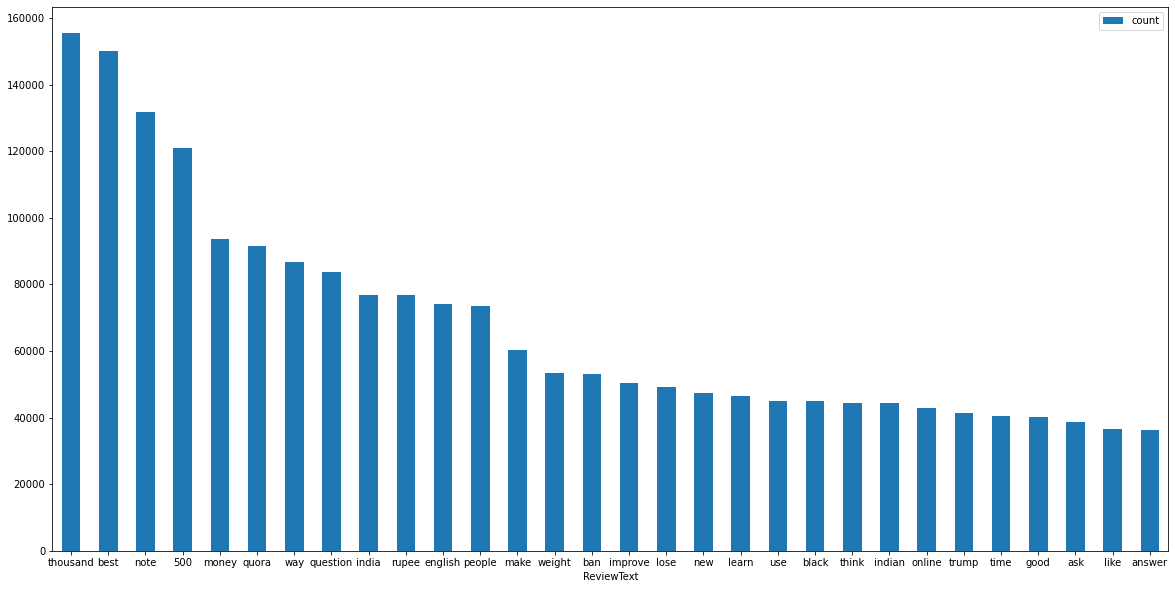

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(sentence_list, 30)
df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df2.plot.bar(x='ReviewText', y='count', rot=0, figsize=(20,10))


In [ ]:
pd.read_csv("fulltrain_cleaned.csv")[['question1', 'question2', 'is_duplicate',
       'question1_cleaned', 'question2_cleaned',
       'question1_stopwords_lemmatize', 'question2_stopwords_lemmatize',
       'question1_stopwords', 'question2_stopwords']]

,question1,question2,is_duplicate,question1_cleaned,question2_cleaned,question1_stopwords_lemmatize,question2_stopwords_lemmatize,question1_stopwords,question2_stopwords
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,step step guide invest share market india,step step guide invest share market,step step guide invest share market india,step step guide invest share market
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,increase speed internet connection use vpn,internet speed increase hack dns,increase speed internet connection using vpn,internet speed increased hacking dns
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math is div...,mentally lonely solve,find remainder math 23 24 math divide 24 23,mentally lonely solve,find remainder math 23 24 math divided 24 23
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,one dissolve water quikly sugar salt methane c...,fish would survive salt water,one dissolve water quikly sugar salt methane c...,fish would survive salt water
...,...,...,...,...,...,...,...,...,...
800164,What does that mean if a girl calls you crazy?,"If a girl says ""you are crazy"", what does it m...",1,what does that mean if a girl calls you crazy,if a girl says you are crazy what does it mean,mean girl call crazy,girl say crazy mean,mean girl calls crazy,girl says crazy mean
800165,How do I determine if I am bisexual or lesbian?,"Am I bisexual, lesbian or straight?",1,how do i determine if i am bisexual or lesbian,am i bisexual lesbian or straight,determine bisexual lesbian,bisexual lesbian straight,determine bisexual lesbian,bisexual lesbian straight
800166,How do I determine if I am bisexual or lesbian?,"How do I know if I am bisexual, lesbian or str...",1,how do i determine if i am bisexual or lesbian,how do i know if i am bisexual lesbian or stra...,determine bisexual lesbian,know bisexual lesbian straight,determine bisexual lesbian,know bisexual lesbian straight
800167,What is your favorite vodka drink and why?,What is your favourite vodka?,1,what is your favorite vodka drink and why,what is your favourite vodka,favorite vodka drink,favourite vodka,favorite vodka drink,favourite vodka
